In [ ]:
! pip install adjustText
import numpy as np
import numpy.linalg as lin
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from adjustText import adjust_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget -O data.csv https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv
!wget -O movies.csv https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv


--2023-04-20 12:47:42--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1596528 (1.5M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.52M  --.-KB/s    in 0.05s   

2023-04-20 12:47:42 (27.9 MB/s) - ‘data.csv’ saved [1596528/1596528]

--2023-04-20 12:47:42--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
from numpy.random.mtrand import gamma

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))


def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))


def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    error = 0
    for y in Y:
        i = int(y[0] - 1)
        j = int(y[1] - 1)
        ij = y[2]
        error += (ij - np.dot(U[i], V[j])) ** 2

    norms = reg * ((lin.norm(U)) ** 2 + (lin.norm(V)) ** 2)
    result = 0.5 * (norms + error) * (1 / len(Y))
    return result


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))

    init_loss = get_err(U, V, Y, reg)

    R = np.random.permutation(len(Y))
    for r in R:
        i = int(Y[r][0] - 1)
        j = int(Y[r][1] - 1)
        ij = Y[r][2]
        U[i] = U[i] - grad_U(U[i], ij, V[j], reg, eta)
        V[j] = V[j] - grad_V(V[j], ij, U[i], reg, eta)
    init_diff = get_err(U, V, Y, reg) - init_loss
    curr_loss = init_loss
    for epoch in range(1, max_epochs):
        prev_loss = get_err(U, V, Y, reg)
        R = np.random.permutation(len(Y))
        for r in R:
            i = int(Y[r][0] - 1)
            j = int(Y[r][1] - 1)
            ij = Y[r][2]
            U[i] = U[i] - grad_U(U[i], ij, V[j], reg, eta)
            V[j] = V[j] - grad_V(V[j], ij, U[i], reg, eta)
        curr_loss = get_err(U, V, Y, reg)
        curr_diff = curr_loss - prev_loss
        if curr_diff <= eps * init_diff:
            break
    return U, V, curr_loss


In [ ]:
data_set = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv")
movie_set = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")

print(data_set)

Y = np.array(data_set)
random.shuffle(Y)
Y_train = Y[0:109351]
Y_test = Y[109351:121501]
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
M += 1
N += 1
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate

U, V, err = train_model(M, N, K, eta, reg, Y_train)

print(f"Training error: {err}")
print(f"Testing error: {get_err(U, V, Y_test)}")

        User ID  Movie ID  Rating
0             0        88     4.0
1             0       545     3.5
2             0         7     3.0
3             0       401     4.0
4             0      1230     0.5
...         ...       ...     ...
121496      991       681     1.0
121497      991       736     3.5
121498      991       162     3.0
121499      991      1242     3.5
121500      991       321     4.5

[121501 rows x 3 columns]
Factorizing with  991  users,  1500  movies.
Training error: 0.2339462807240652
Testing error: 0.9262073920173128


In [ ]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    :param dataset_path: MovieLens dataset path
    Reference:
        https://grouplens.org/datasets/movielens
    """

    def __init__(self, dataset_path, sep=',', engine='c', header='infer'):
        data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header).to_numpy()[:, :3]
        self.items = data[:, :2].astype(np.int)
        self.targets = data[:, 2].astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target

In [ ]:
# Read data.csv into a MovieLensDataSet
data_set = MovieLensDataset("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv")
# Read movies.csv and make dict of movie titles to movie ids
movie_titles = movie_set["Movie Title"].tolist()
movie_ids = movie_set["Movie ID"].tolist()
movie_dict = dict(zip(movie_titles, movie_ids))

# Make a list of movie IDs for each genre
action_ids = movie_set[movie_set["Action"] == 1]["Movie ID"].tolist()
adventure_ids = movie_set[movie_set["Adventure"] == 1]["Movie ID"].tolist()
animation_ids = movie_set[movie_set["Animation"] == 1]["Movie ID"].tolist()
children_ids = movie_set[movie_set["Children"] == 1]["Movie ID"].tolist()
comedy_ids = movie_set[movie_set["Comedy"] == 1]["Movie ID"].tolist()
crime_ids = movie_set[movie_set["Crime"] == 1]["Movie ID"].tolist()
documentary_ids = movie_set[movie_set["Documentary"] == 1]["Movie ID"].tolist()

<ipython-input-148-c0ffee7af81c>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.items = data[:, :2].astype(np.int)
<ipython-input-148-c0ffee7af81c>:16: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `

In [ ]:
ratings = data_set.items[:,1]
counts = np.bincount(ratings)

avg_ratings = np.zeros(len(counts))
for i in range(len(avg_ratings)):
  avg_ratings[i] = np.mean(data_set.targets[data_set.items[:,1] == i])

popular_movie_ids = np.argsort(counts)[::-1]

top_movie_ids = np.argsort(avg_ratings)[::-1]

print("Top 10 movies by number of ratings:")
for i in range(10):
  print(f"{movie_titles[popular_movie_ids[i]]}: {counts[popular_movie_ids[i]]} ratings")


Top 10 movies by number of ratings:
Lord of the Rings: The Fellowship of the Ring, The (2001): 747 ratings
Lord of the Rings: The Two Towers, The (2002): 713 ratings
Lord of the Rings: The Return of the King, The (2003): 698 ratings
Shrek (2001): 610 ratings
Pirates of the Caribbean: The Curse of the Black Pearl (2003): 585 ratings
Dark Knight, The (2008): 561 ratings
Finding Nemo (2003): 528 ratings
Kill Bill: Vol. 1 (2003): 520 ratings
Monsters, Inc. (2001): 519 ratings
Ocean's Eleven (2001): 517 ratings


In [ ]:
mid = movie_dict["The Hunger Games (2012)"]
movie_embedding = V
vec = movie_embedding[mid]

cosine_sim = np.dot(movie_embedding, vec) / (np.linalg.norm(movie_embedding, axis=1) * np.linalg.norm(vec))
top_10 = np.argsort(cosine_sim)[:-20:-1]

for id in top_10:
    print(movie_titles[id])

The Hunger Games (2012)
Expendables 2, The (2012)
Dark Knight, The (2008)
Green Zone (2010)
Avengers: Infinity War - Part I (2018)
Revolutionary Road (2008)
The Lego Movie (2014)
Heat, The (2013)
Men Who Stare at Goats, The (2009)
The Accountant (2016)
Pacific Rim (2013)
Assault on Precinct 13 (2005)
Good Girl, The (2002)
Little Miss Sunshine (2006)
Funny People (2009)
Stranger than Fiction (2006)
Igby Goes Down (2002)
Thirteen Ghosts (a.k.a. Thir13en Ghosts) (2001)
Tokyo Godfathers (2003)


In [ ]:
V = movie_embedding.T
V -= np.mean(V, axis=0)

A, s, B = np.linalg.svd(V, full_matrices=False)
print(V.shape, A.shape)
proj = A[:,:2].T @ V
print(proj.shape)
n = 10

def plot_svd(movie_list, filename=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(proj[0], proj[1], alpha=0.3)
    if filename is not None:
      plt.title(filename)
    var = plt.scatter(proj[0, movie_list], proj[1, movie_list])
    texts = [plt.text(proj[0, id], proj[1, id], movie_titles[id]) for id in movie_list]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="w")

    plt.show()

def title_to_id(title_arr, movie_dict):
  for i in range(len(title_arr)):
    title_arr[i] = movie_dict[title_arr[i]]


(20, 1500) (20, 20)
(2, 1500)


In [ ]:
TEN_MOVIES = [
    "Black Mirror: White Christmas (2014)",
    "Big Hero 6 (2014)",
    "Identity (2003)",
    "Mamma Mia! (2008)",
    "Grand Budapest Hotel, The (2014)",
    "Freaky Friday (2003)",
    "Fantastic Beasts and Where to Find Them (2016)",
    "Divergent (2014)",
    "Doctor Strange (2016)",
    "National Treasure (2004)"
]
title_to_id(TEN_MOVIES, movie_dict)
ACTION = np.random.choice(action_ids, n)

CRIME = np.random.choice(crime_ids, n)

COMEDY = np.random.choice(comedy_ids, n)


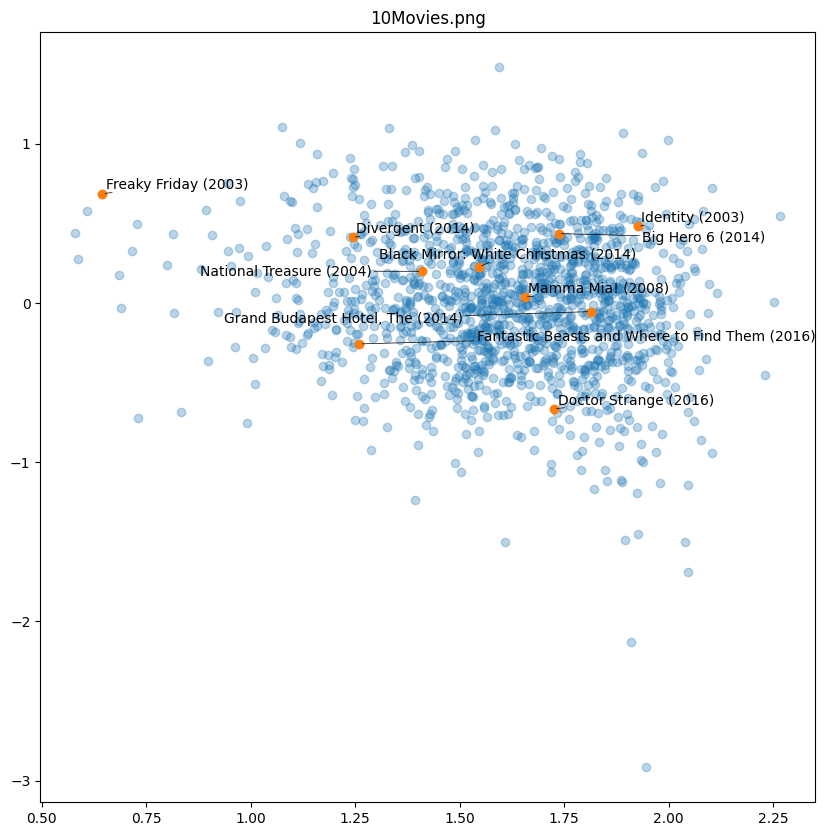

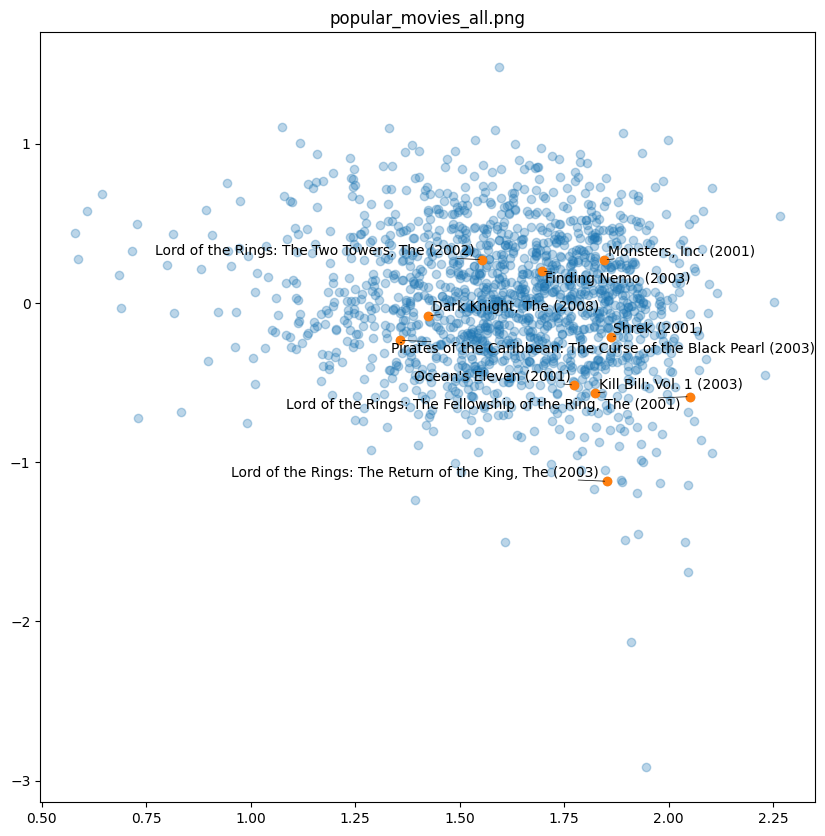

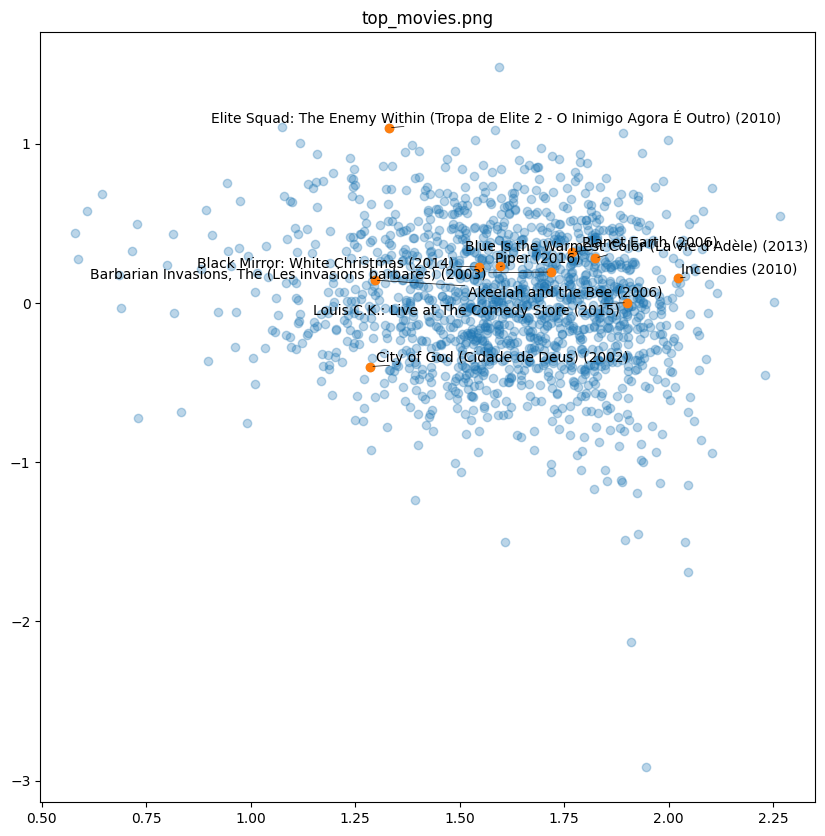

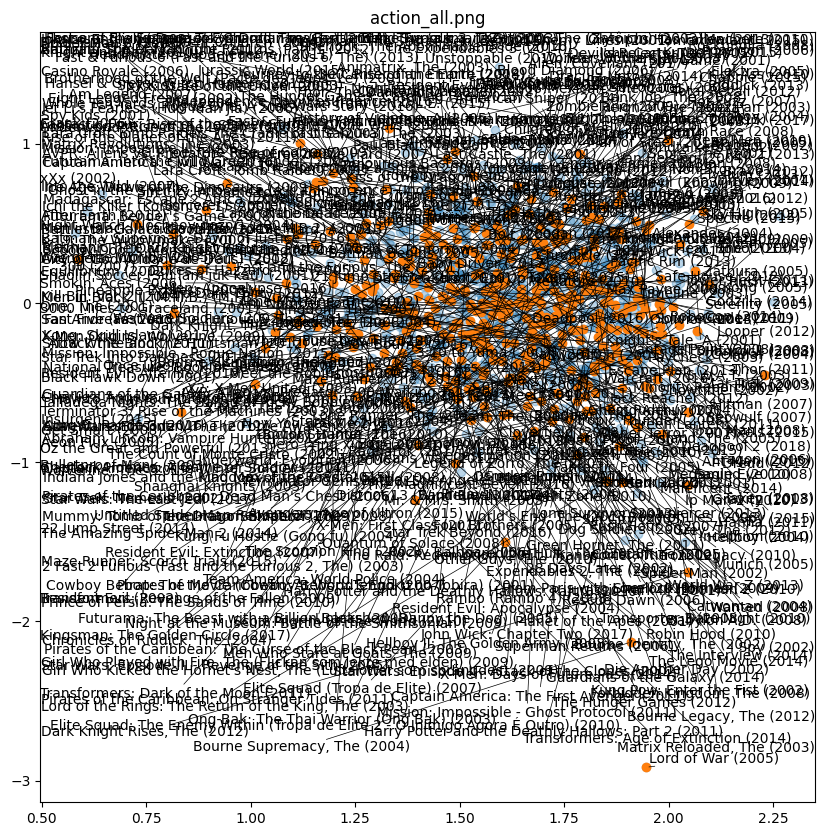

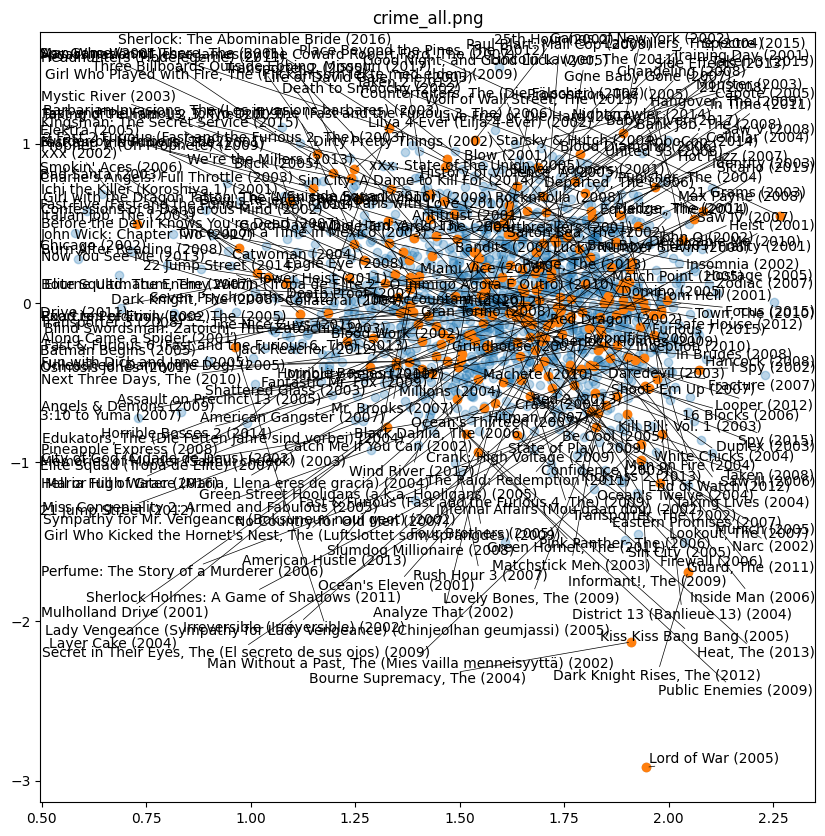

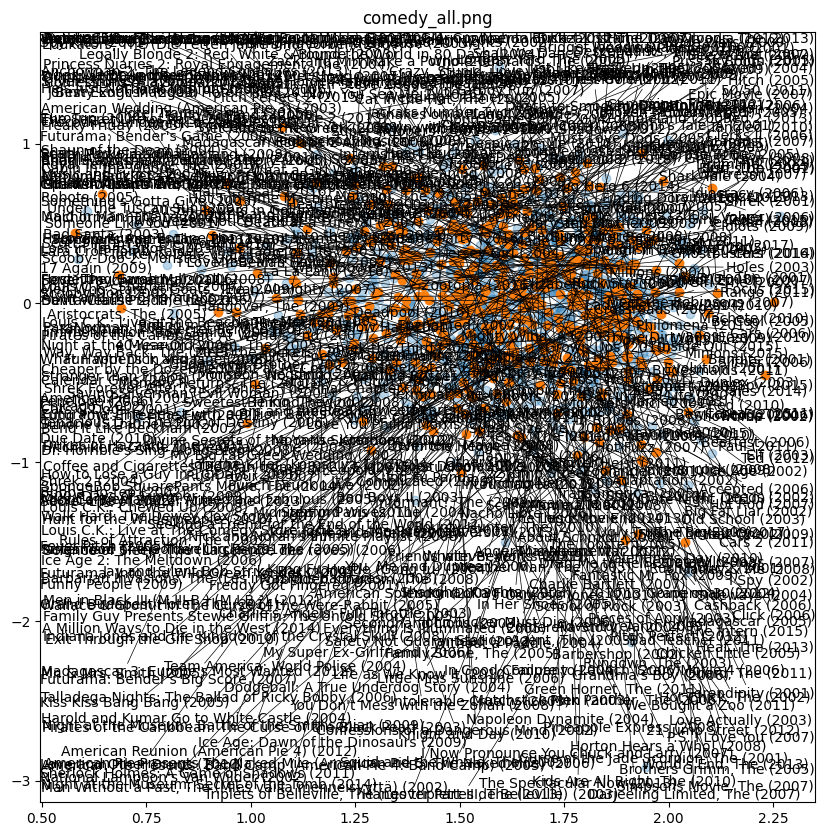

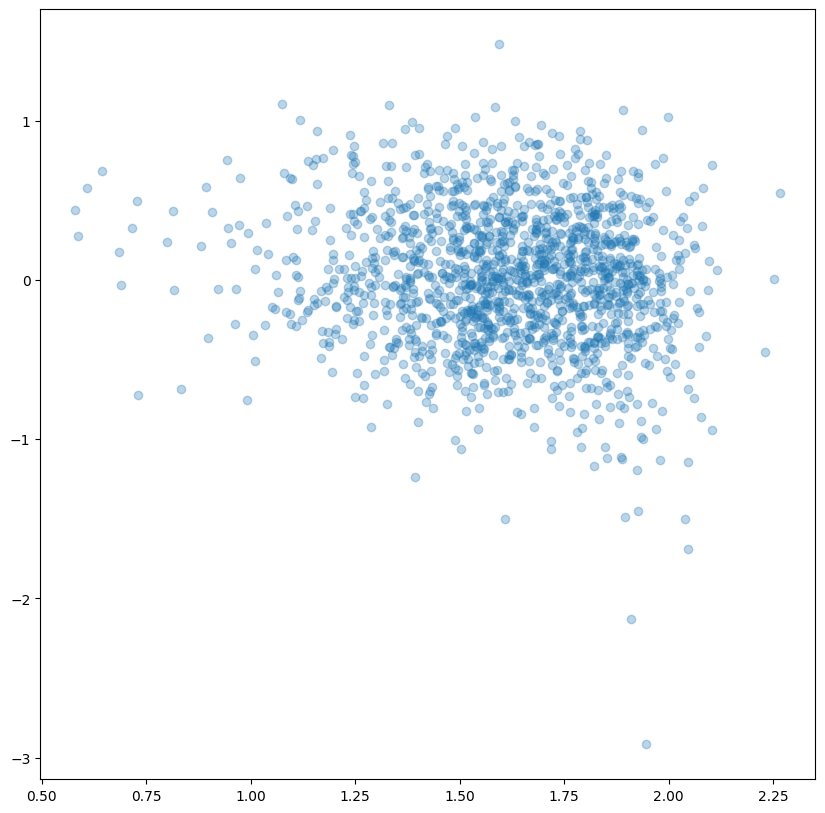

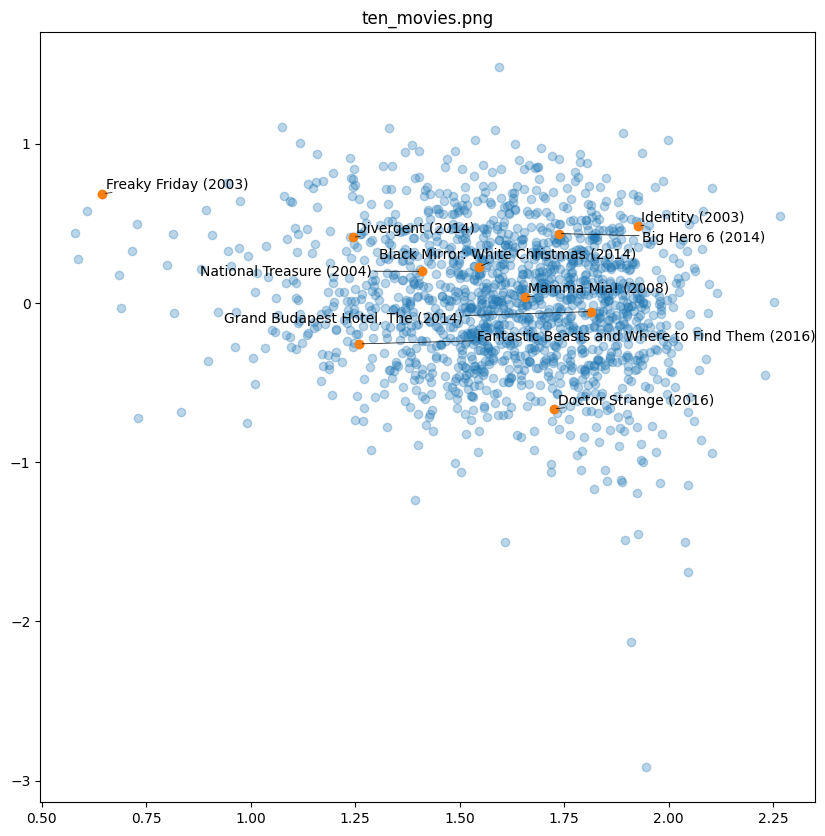

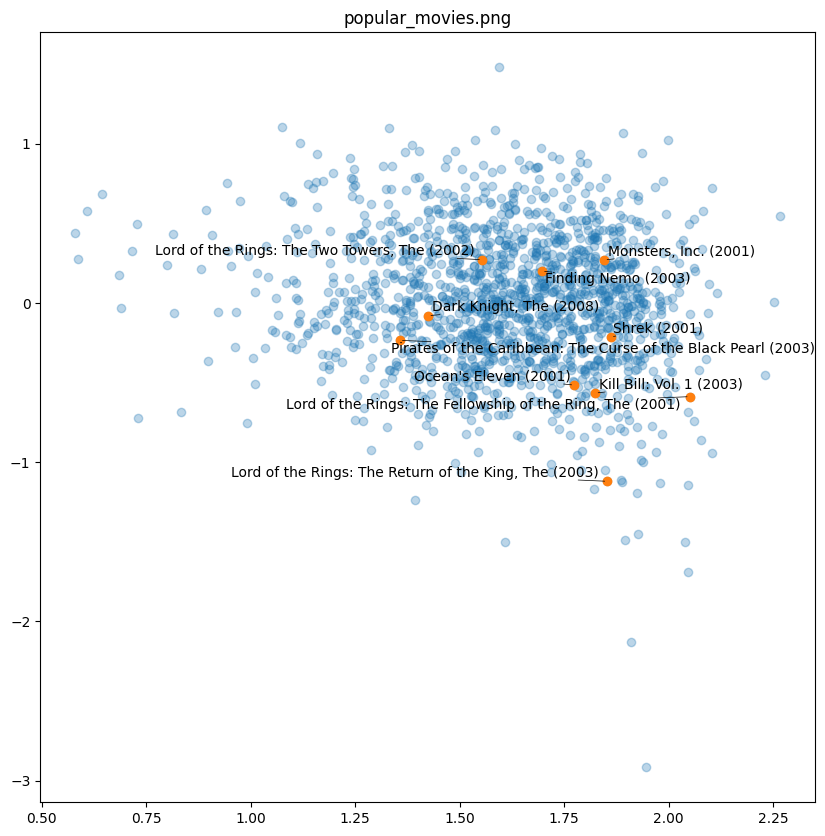

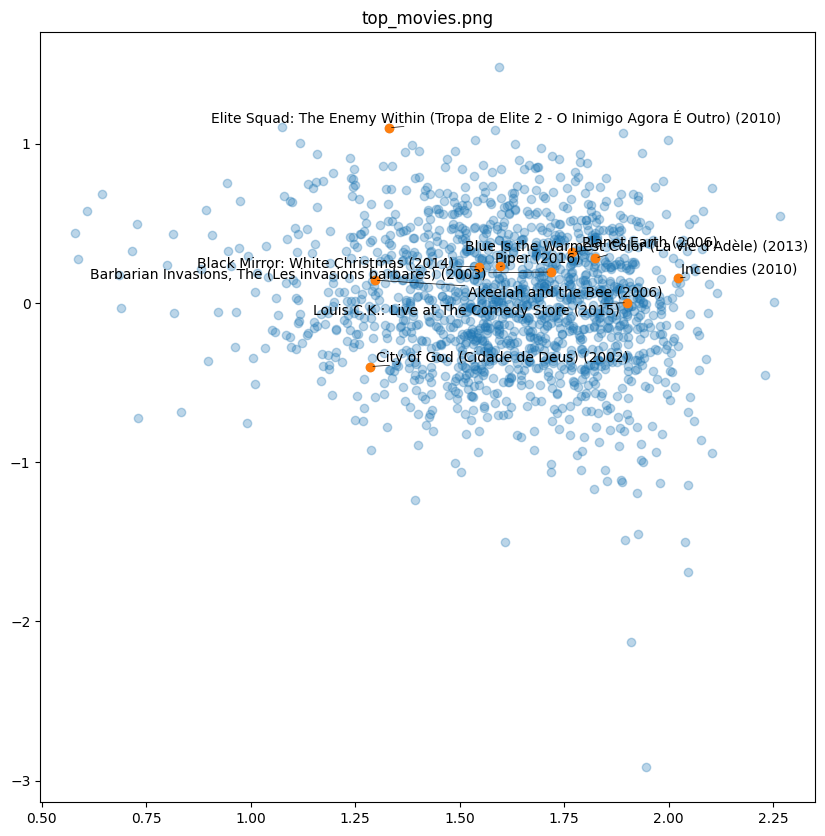

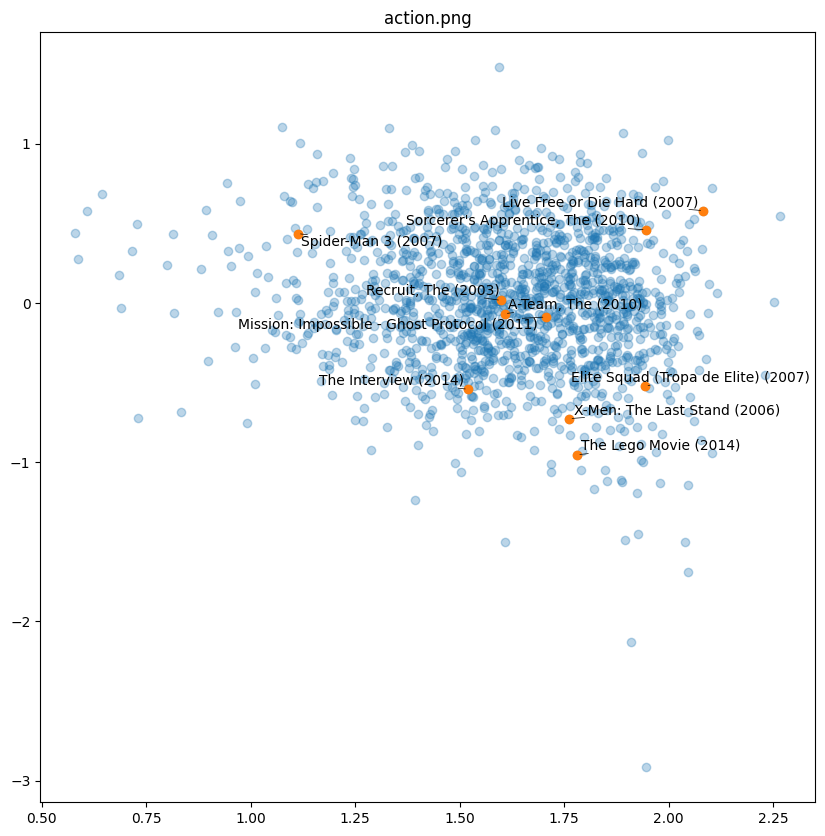

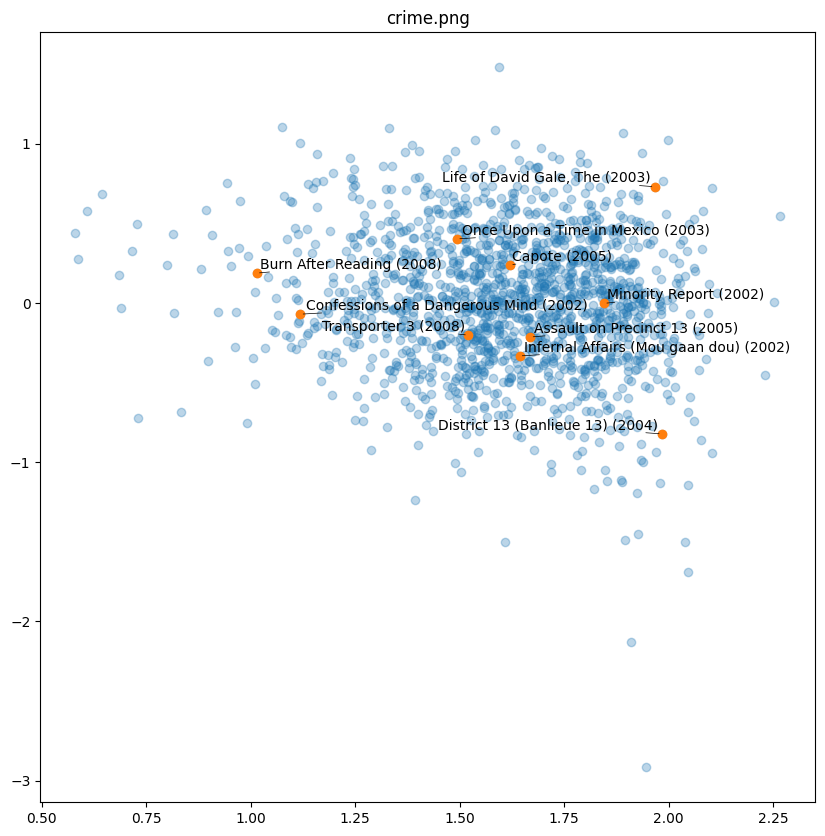

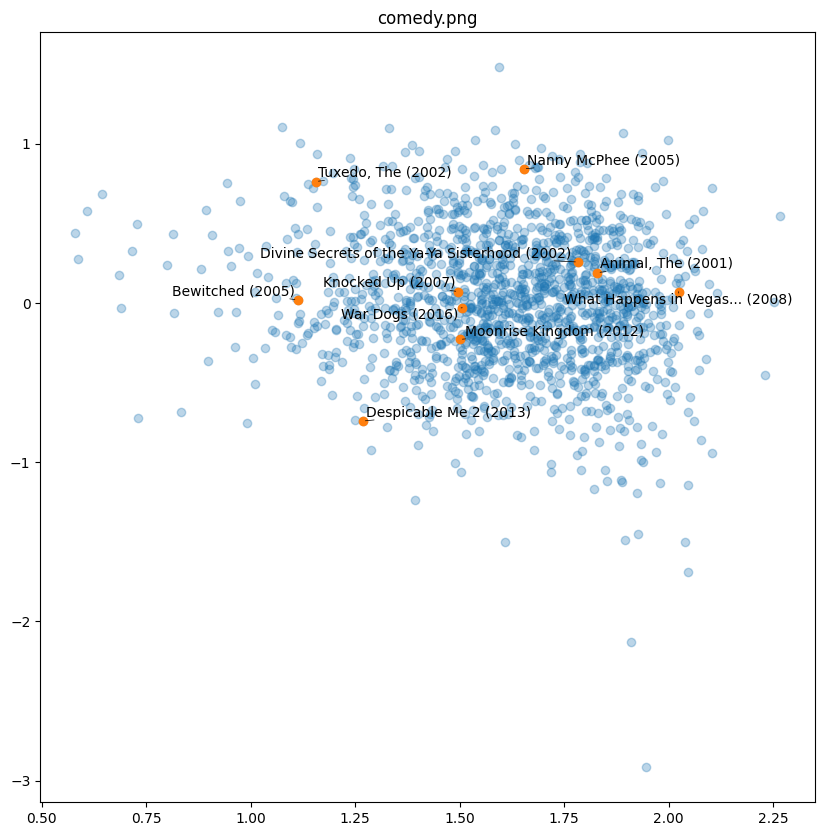

In [ ]:
plot_svd(TEN_MOVIES, "10Movies.png")
plot_svd(popular_movie_ids[:n], "popular_movies_all.png")
plot_svd(top_movie_ids[:n], "top_movies.png")
plot_svd(action_ids, "action_all.png")
plot_svd(crime_ids, "crime_all.png")
plot_svd(comedy_ids, "comedy_all.png")


plt.figure(figsize=(10, 10))
plt.scatter(proj[0], proj[1], alpha=0.3)
plt.savefig("all_movies.png", dpi=300, bbox_inches="tight", facecolor="w")

plot_svd(TEN_MOVIES, "ten_movies.png")
plot_svd(popular_movie_ids[:n], "popular_movies.png")
plot_svd(top_movie_ids[:n], "top_movies.png")
plot_svd(ACTION, "action.png")
plot_svd(CRIME, "crime.png")
plot_svd(COMEDY, "comedy.png")

In [ ]:
def grad_U (Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """

    return eta * (reg * Ui - Vj * (Yij - (np.dot(Ui, Vj) + ai + bj)))


def grad_V (Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - (np.dot(Ui, Vj) + ai + bj)))


def grad_a (Ui, Yij, Vj, ai, bj, eta):
    return -eta * (Yij - np.dot(Ui, Vj) - ai - bj)

def grad_b(Ui, Yij, Vj, ai, bj, eta):
    return -eta * (Yij - np.dot(Ui, Vj) - ai - bj)

def get_err (U, V, Y, a, b, reg=0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    error = 0
    for y in Y:
        i = int(y[0] - 1)
        j = int(y[1] - 1)
        ai = a[i]
        bj = b[j]
        ij = y[2]
        error += (ij - (np.dot(U[i], V[j]) + ai + bj)) ** 2
    norms = reg * ((lin.norm(U)) ** 2 + (lin.norm(V)) ** 2)
    result = 0.5 * (norms + error) * (1 / len(Y))
    return result


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))
    a = np.random.uniform(-0.5, 0.5, size=M)
    b = np.random.uniform(-0.5, 0.5, size=N)

    init_loss = get_err(U, V, Y, a, b, reg)

    R = np.random.permutation(len(Y))
    for r in R:
        i = int(Y[r][0] - 1)
        j = int(Y[r][1] - 1)
        ai = a[i]
        bj = b[j]
        ij = Y[r][2]
        U[i] = U[i] - grad_U(U[i], ij, V[j], ai, bj, reg, eta)
        V[j] = V[j] - grad_V(V[j], ij, U[i], ai, bj, reg, eta)
        a[i] = a[i] - grad_a(U[i], ij, V[j], ai, bj, eta)
        b[j] = b[j] - grad_a(U[i], ij, V[j], ai, bj, eta)
    init_diff = get_err(U, V, Y, a, b, reg) - init_loss
    curr_loss = init_loss
    for epoch in range(1, max_epochs):
        prev_loss = get_err(U, V, Y, a, b, reg)
        R = np.random.permutation(len(Y))
        for r in R:
            i = int(Y[r][0] - 1)
            j = int(Y[r][1] - 1)
            ij = Y[r][2]
            ai = a[i]
            bj = b[j]
            U[i] = U[i] - grad_U(U[i], ij, V[j], ai, bj, reg, eta)
            V[j] = V[j] - grad_V(V[j], ij, U[i], ai, bj, reg, eta)
        curr_loss = get_err(U, V, Y, a, b,reg)
        curr_diff = curr_loss - prev_loss
        if curr_diff <= eps * init_diff:
            break
    return U, V, a, b, curr_loss


Training error: 0.22915352363443997
Testing error: 0.7726768891509036
The Hunger Games (2012)
Rescue Dawn (2006)
City of God (Cidade de Deus) (2002)
Little Miss Sunshine (2006)
Silent Hill (2006)
Milk (2008)
Tokyo Godfathers (2003)
Underworld: Awakening (2012)
Reign Over Me (2007)
Sherlock: The Abominable Bride (2016)
Date Night (2010)
Captain America: Civil War (2016)
Day the Earth Stood Still, The (2008)
Looper (2012)
Pirates of the Caribbean: Dead Man's Chest (2006)
Quiet American, The (2002)
My Big Fat Greek Wedding (2002)
Disturbia (2007)
American Pie 2 (2001)
(20, 1500) (20, 20)
(2, 1500)


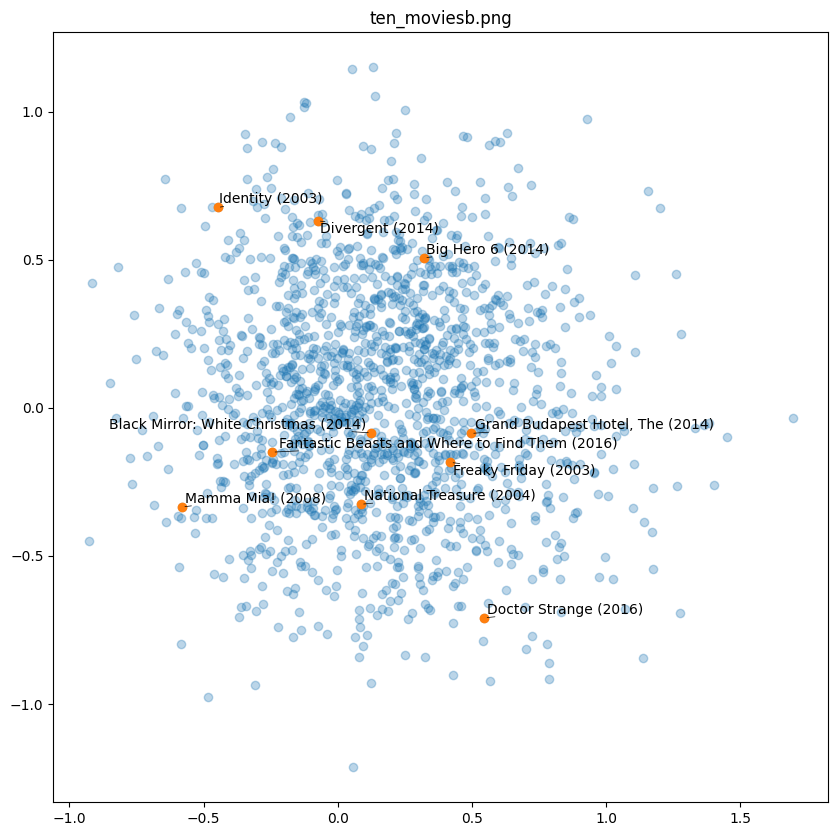

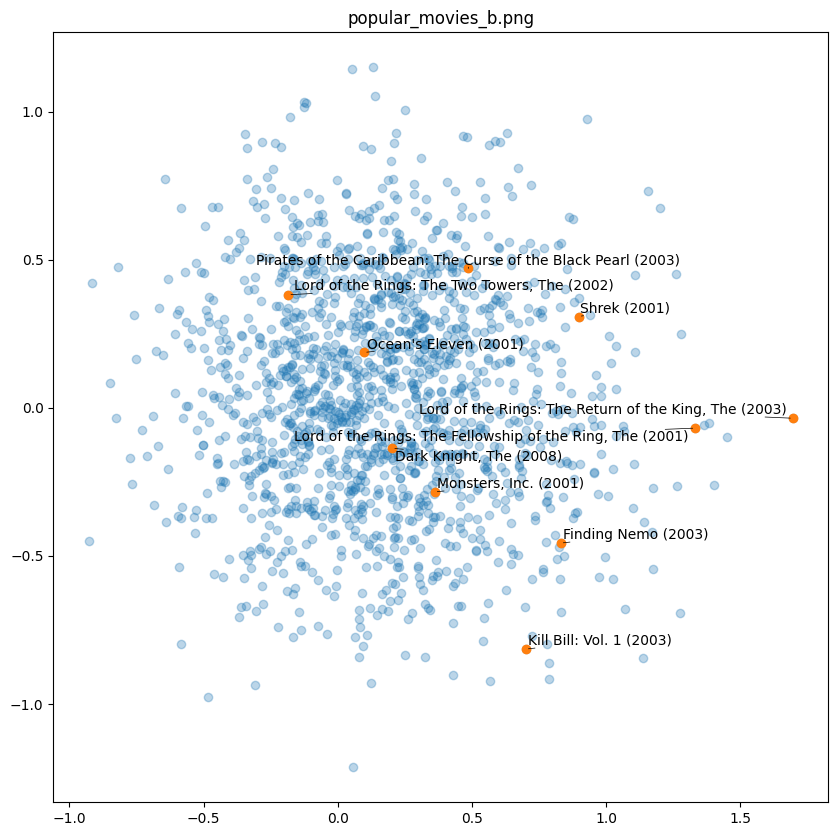

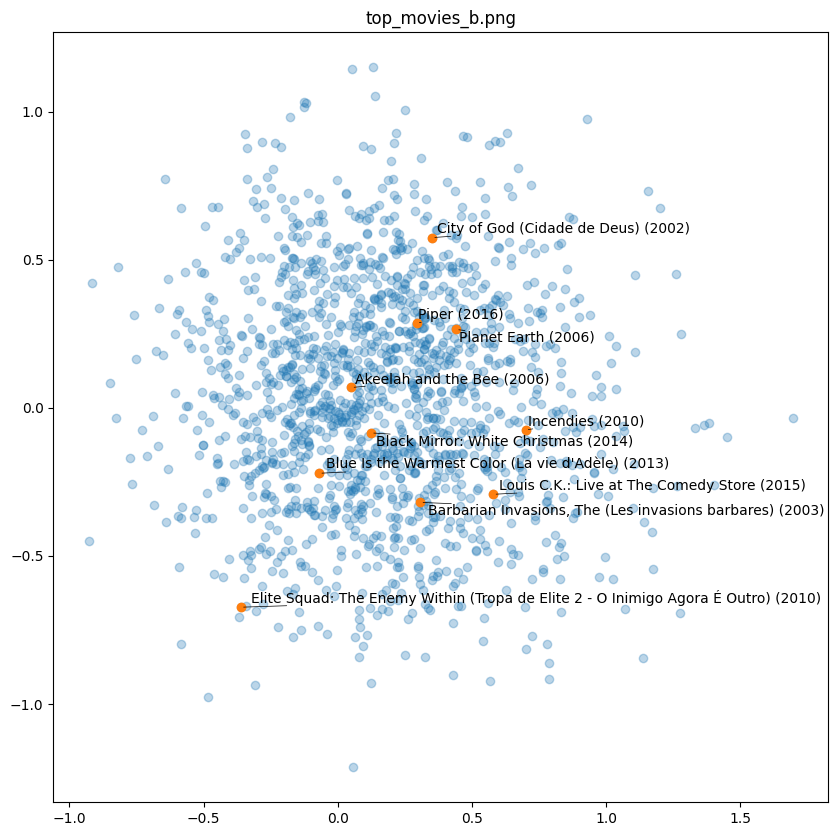

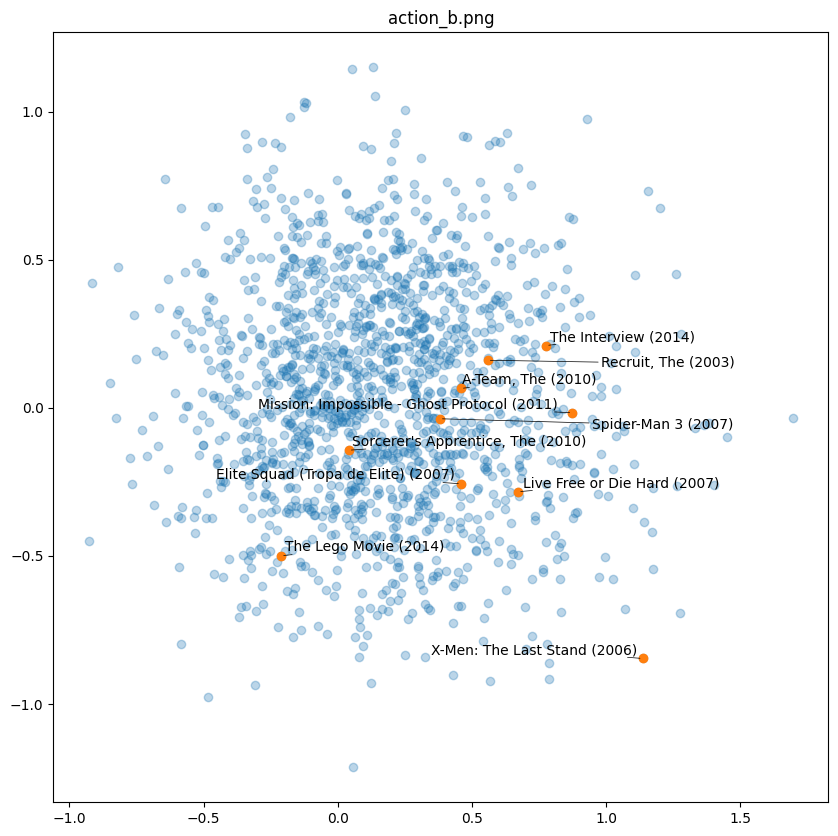

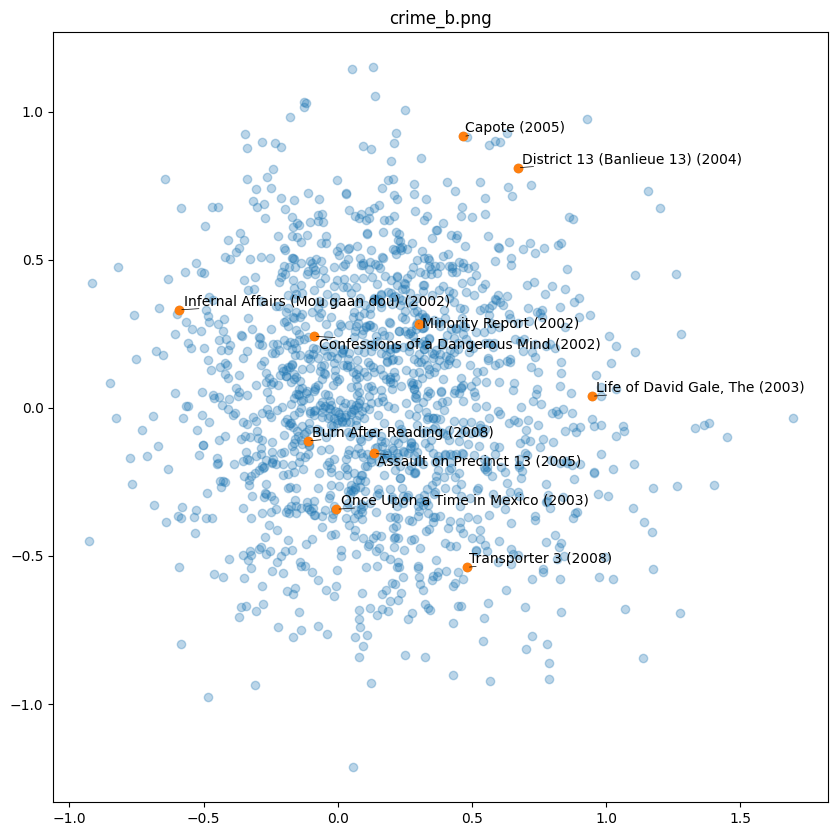

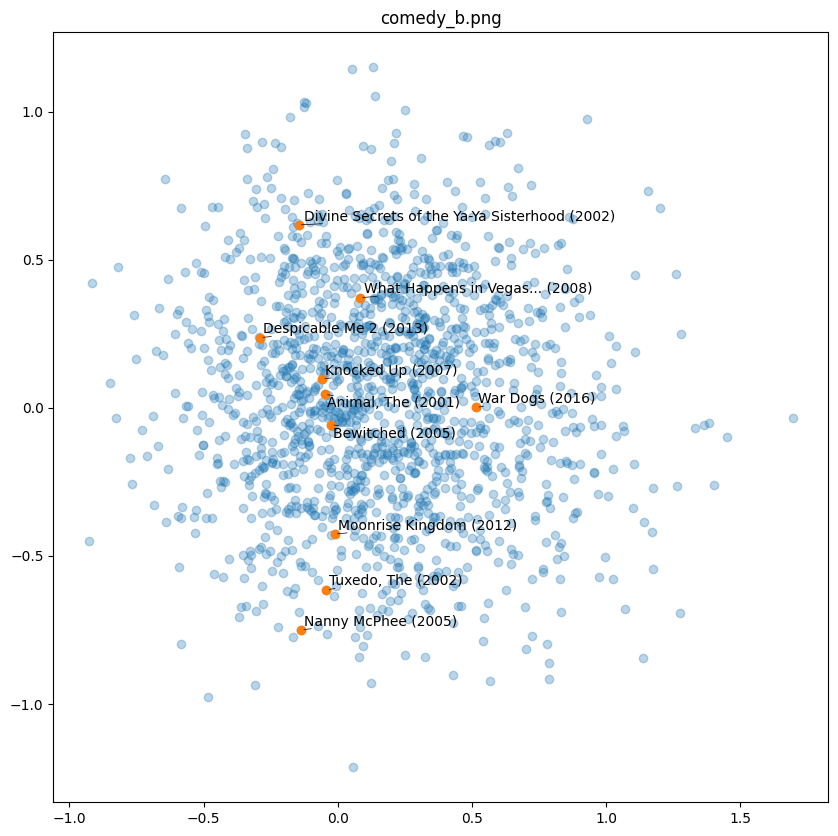

In [ ]:
U, V, a, b, err = train_model(M, N, K, eta, reg, Y_train)

print(f"Training error: {err}")
print(f"Testing error: {get_err(U, V, Y_test, a, b)}")

mid = movie_dict["The Hunger Games (2012)"]
movie_embedding = V
vec = movie_embedding[mid]

# Find cosine similarity between movie and all other movies
cosine_sim = np.dot(movie_embedding, vec) / (np.linalg.norm(movie_embedding, axis=1) * np.linalg.norm(vec))
top_10 = np.argsort(cosine_sim)[:-20:-1]

for id in top_10:
    print(movie_titles[id])

V = movie_embedding.T
V -= np.mean(V, axis=0)

A, s, B = np.linalg.svd(V, full_matrices=False)
print(V.shape, A.shape)
proj = A[:,:2].T @ V
print(proj.shape)
n = 10


plot_svd(TEN_MOVIES, "ten_moviesb.png")
plot_svd(popular_movie_ids[:n], "popular_movies_b.png")
plot_svd(top_movie_ids[:n], "top_movies_b.png")
plot_svd(ACTION, "action_b.png")
plot_svd(CRIME, "crime_b.png")
plot_svd(COMEDY, "comedy_b.png")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


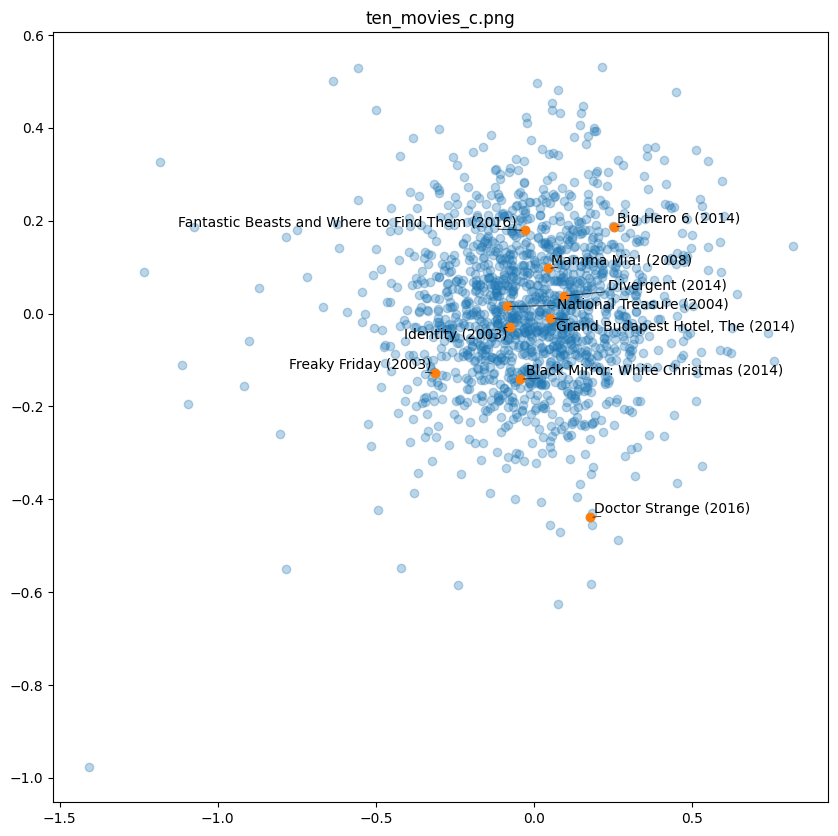

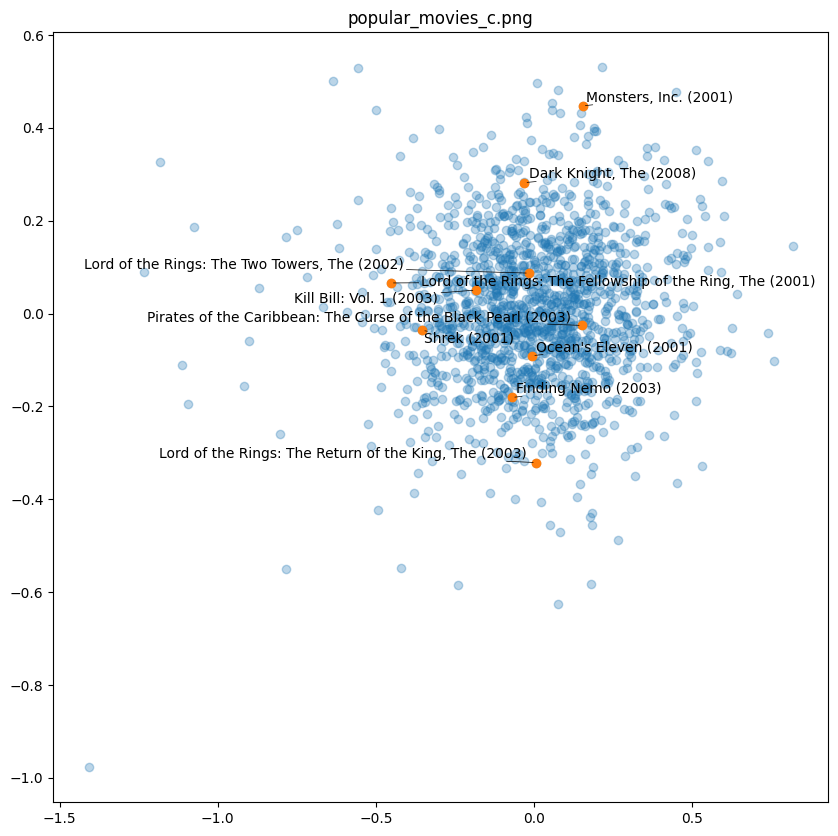

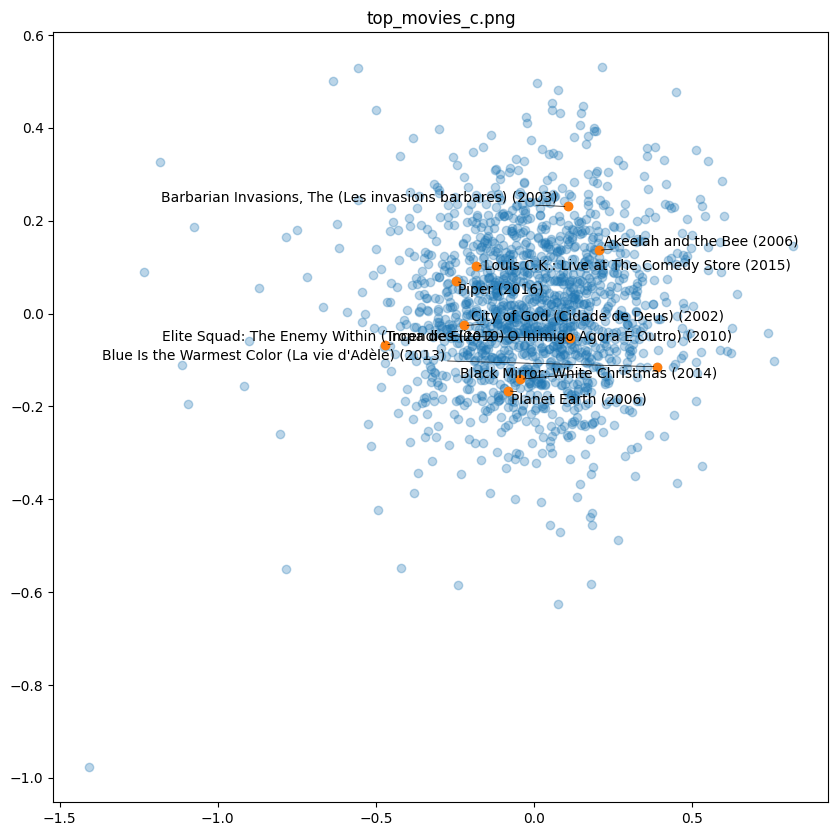

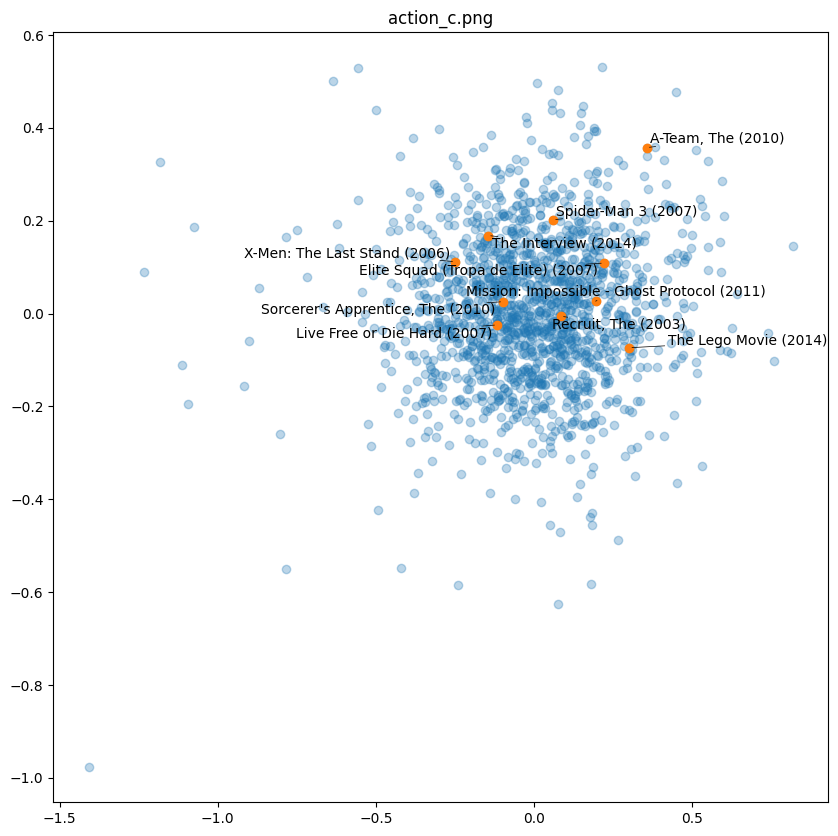

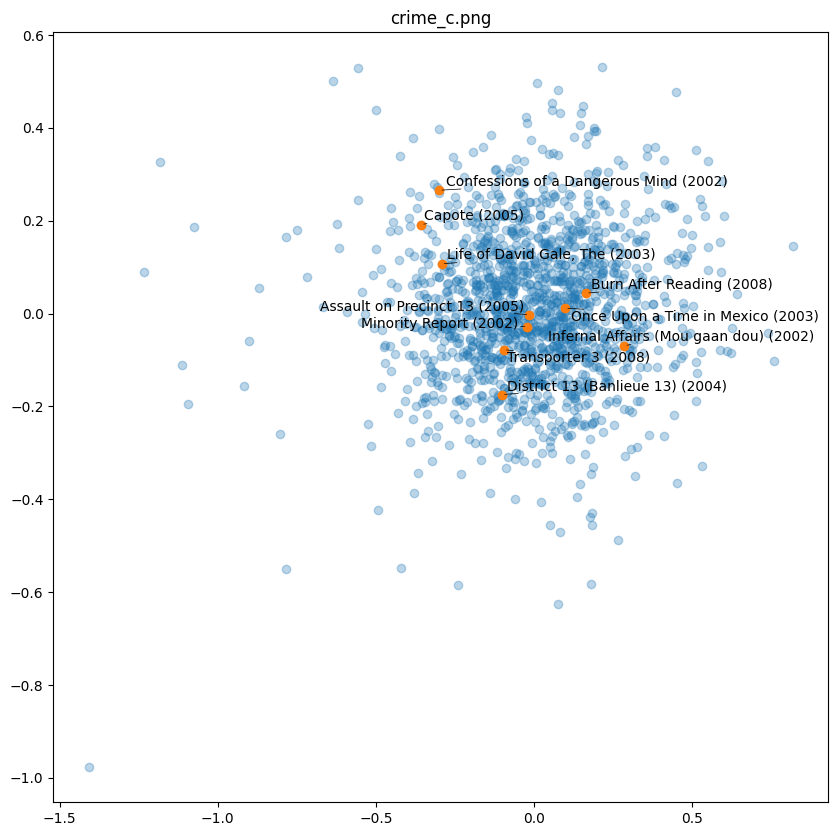

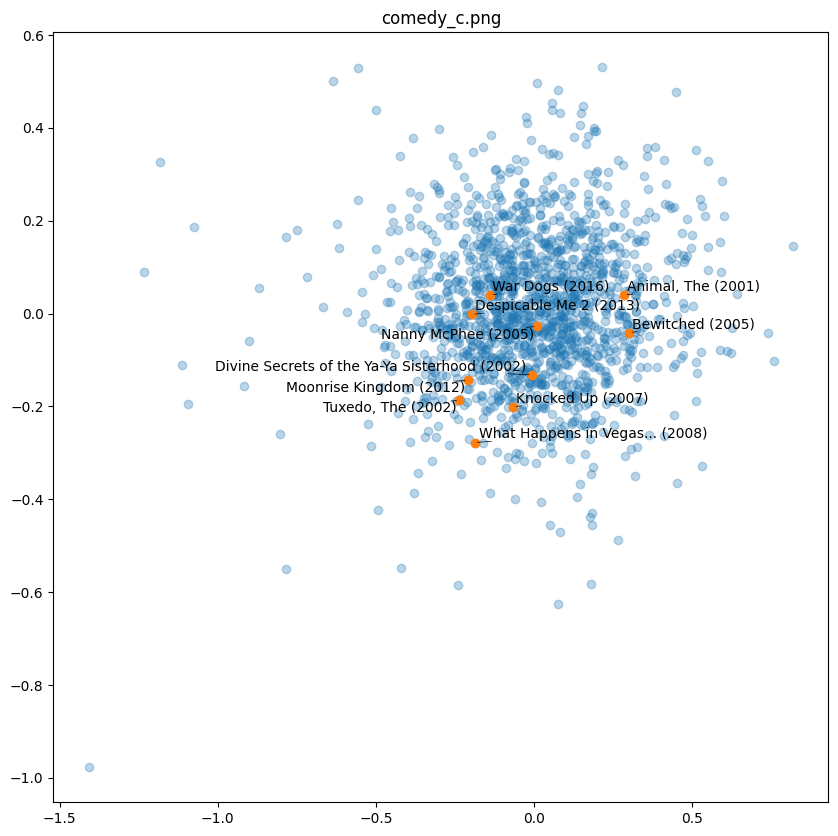

In [ ]:
! pip install surprise
import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

reader = surprise.Reader(line_format=u'user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_from_file("data.csv", reader=reader)
trainset = data.build_full_trainset()

# Use the famous SVD algorithm.

s = SVD()

algo = s.fit(trainset)

U, V = algo.pu, algo.qi

proj = U @ V.T


n = 10
plot_svd(TEN_MOVIES, "ten_movies_c.png")
plot_svd(popular_movie_ids[:n], "popular_movies_c.png")
plot_svd(top_movie_ids[:n], "top_movies_c.png")
plot_svd(ACTION, "action_c.png")
plot_svd(CRIME, "crime_c.png")
plot_svd(COMEDY, "comedy_c.png")